# STA365
Homework 4

---

### Question 1

Convert your **Gibbs sampler** from the previous homework to be a **Metropolis within Gibbs** sampler. 
- Do not derive any full conditionals and instead just use the joint distribution which is the product of the likelihood with the priors 
    - Note that in fact you must only be proportional to the joint since irrelevant priors of "the other parameter" will cancel in the ratio
- Note that $\tau$ must be positive so proposals $\tilde \tau$ must also be positive. The easiest way to achieve this would be to use independent samples (that do not depend on $\tau^{(t-1)}$ from exponential, half normal, gamma, or inverse gamma distributions (and other distributions defining strictly positive random variables).
- When considering using independent proposal distributions one option of some note is to use the prior $p(\tau)$ as this proposal distribution

*Clearly articulate your specification and provide a demonstration showing the Bayesian inference it provides, in contrast to that of your previous Gibbs sampler (of Q2 from the last homework).*

*Answer:*

From HW3 Q2, $x_i \text{~} \mathcal{N}(\theta, \tau^{-1})$ where $\theta$ is the mean and $\tau$ is the precision (inverse variance).

The priors are:

$$p(\theta) \text{~} \mathcal{N}(\theta_0, \tau_0^2)$$

$$p(\tau) \text{~} \text{Gamma}(\frac{\alpha}{2}, \frac{\lambda}{2})$$

To sample $\tau$ using Metropolis-Hastings,

1. Propose $\tilde{\tau}$ from a Gamma distribution.
2. Compute the Metropolis acceptance ratio:
    $$ A = \min \left( 1, \frac{p(x | \theta, \tilde{\tau}) p(\tilde{\tau})}{p(x | \theta, \tau) p(\tau)} \times \frac{q(\tau | \tilde{\tau})}{q(\tilde{\tau} | \tau)} \right)$$
3. Accept or reject the proposal

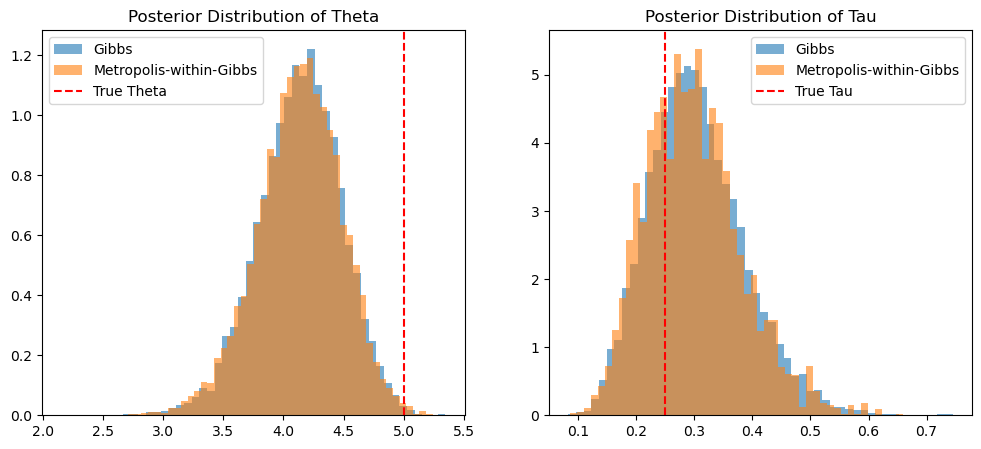

Metropolis-Hastings Acceptance Rate for Tau: 0.168


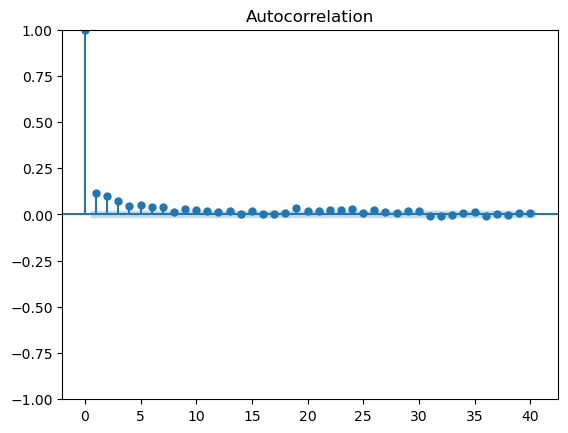

In [3]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import arviz as az
import statsmodels.api as sm

# Simulated data
np.random.seed(42)
n = 30
theta_true = 5
sigma_true = 2
x = np.random.normal(loc=theta_true, scale=sigma_true, size=n)

# Prior hyperparameters
theta_0 = 0  # Prior mean for theta
tau_0 = 1    # Prior variance
alpha = 2    # Shape for Gamma prior on tau
lambda_ = 2  # Rate for Gamma prior on tau

# Gibbs sampler function
def gibbs_sampler(num_samples):
    theta_samples = np.zeros(num_samples)
    tau_samples = np.zeros(num_samples)
    
    # Initial values
    theta_samples[0] = np.mean(x)
    tau_samples[0] = 1 / np.var(x)

    for i in range(1, num_samples):
        # Sample theta from Normal
        tau_inv = 1 / tau_samples[i - 1]
        theta_n = (tau_0**-2 * theta_0 + n * tau_samples[i - 1] * np.mean(x)) / (tau_0**-2 + n * tau_samples[i - 1])
        tau_n2 = 1 / (tau_0**-2 + n * tau_samples[i - 1])
        theta_samples[i] = np.random.normal(theta_n, np.sqrt(tau_n2))

        # Sample tau from Gamma (direct Gibbs step)
        shape = alpha / 2 + n / 2
        scale = 2 / (lambda_ + np.sum((x - theta_samples[i]) ** 2))
        tau_samples[i] = np.random.gamma(shape, scale)

    return theta_samples, tau_samples

# Metropolis-Within-Gibbs sampler function
def metropolis_within_gibbs(num_samples):
    theta_samples = np.zeros(num_samples)
    tau_samples = np.zeros(num_samples)
    
    # Initial values
    theta_samples[0] = np.mean(x)
    tau_samples[0] = 1 / np.var(x)

    acceptance_count = 0  # Track accepted proposals

    for i in range(1, num_samples):
        # Sample theta from Normal (Gibbs step)
        tau_inv = 1 / tau_samples[i - 1]
        theta_n = (tau_0**-2 * theta_0 + n * tau_samples[i - 1] * np.mean(x)) / (tau_0**-2 + n * tau_samples[i - 1])
        tau_n2 = 1 / (tau_0**-2 + n * tau_samples[i - 1])
        theta_samples[i] = np.random.normal(theta_n, np.sqrt(tau_n2))

        # Metropolis-Hastings step for tau
        tau_current = tau_samples[i - 1]
        tau_proposal = np.random.gamma(shape=alpha / 2, scale=2 / lambda_)

        # Compute acceptance ratio
        likelihood_proposed = np.prod(stats.norm.pdf(x, loc=theta_samples[i], scale=1/np.sqrt(tau_proposal)))
        likelihood_current = np.prod(stats.norm.pdf(x, loc=theta_samples[i], scale=1/np.sqrt(tau_current)))

        prior_proposed = stats.gamma.pdf(tau_proposal, alpha / 2, scale=2 / lambda_)
        prior_current = stats.gamma.pdf(tau_current, alpha / 2, scale=2 / lambda_)

        acceptance_ratio = min(1, (likelihood_proposed * prior_proposed) / (likelihood_current * prior_current))

        # Accept or reject
        if np.random.rand() < acceptance_ratio:
            tau_samples[i] = tau_proposal
            acceptance_count += 1
        else:
            tau_samples[i] = tau_current

    acceptance_rate = acceptance_count / num_samples
    return theta_samples, tau_samples, acceptance_rate

# Run samplers
num_samples = 10000
theta_gibbs, tau_gibbs = gibbs_sampler(num_samples)
theta_mh, tau_mh, accept_rate = metropolis_within_gibbs(num_samples)

# Plot posterior distributions
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].hist(theta_gibbs, bins=50, density=True, alpha=0.6, label="Gibbs")
ax[0].hist(theta_mh, bins=50, density=True, alpha=0.6, label="Metropolis-within-Gibbs")
ax[0].axvline(theta_true, color="red", linestyle="dashed", label="True Theta")
ax[0].legend()
ax[0].set_title("Posterior Distribution of Theta")

ax[1].hist(tau_gibbs, bins=50, density=True, alpha=0.6, label="Gibbs")
ax[1].hist(tau_mh, bins=50, density=True, alpha=0.6, label="Metropolis-within-Gibbs")
ax[1].axvline(1 / sigma_true**2, color="red", linestyle="dashed", label="True Tau")
ax[1].legend()
ax[1].set_title("Posterior Distribution of Tau")

plt.show()

# Print acceptance rate
print(f"Metropolis-Hastings Acceptance Rate for Tau: {accept_rate:.3f}")


# Plot autocorrelation
sm.graphics.tsa.plot_acf(theta_mh, lags=40)
plt.show()




**Result**

The result of both plots of Posterior Distribution of $\theta$ and $\tau$ shows that both samplers (Gibbs and Metropolis-within-Gibbs) have idenical posterior distributions which suggests good mixing and convergence for both methods. 

However, the Acceptance Rate for the Metropolis-Hastings $\tau$ is 16.8%. Typically this will be considered as a low acceptance rate, which means the proposal is often rejected and the Markoc Chain is not efficient and mixed well. More improvements can be made such as increasing the variance of the proposal distribution and using a proposal closer to the target distribution. So in this case, the Gibbs sampler is consiedered more efficient compared to the Metropolis-within-Gibbs sampler which may take longer to explore the posterior space.

For the autocorrelation, lag 0 has autocorrelation of 1. The first few lags then has some positive autocorrelation but decreases rapidly. After lag 10, the autocorrelation is close to 0 which shows good mixing and generally a good autocorrelation plot.

**Comparison**

In conclusion, the Gibbs sampler that was done in the previous homework directly samples from full conditional distributions which is more efficient for an independent sample. Not to mention, it works more efficiently when the full conditional distribution is known.

This differs from the current approach that the Metropolis-Hastings is using for $\tau$ instead of direct sampling. This method becomes useful as the full conditionals is not always known and can be derived. However, it can be less efficient since the proposal can be rejected just like in the case of this question. However, since the samples are dependent, then the Metropolis step for $\tau$ introduces more autocorrelation.

---
### Question 2

Adjust your **Metropolis within Gibbs** sampler as follows.

- Use the following **dependent** proposal for $\tau$

```Python
stats.truncnorm(a=-tau_t_minus_1/s, b=np.Inf,
                loc=tau_t_minus_1, scale=s)
```

- Use a prior for $\theta$ that is not a normal distribution 


*Provide a demonstration showing the Bayesian inference provided by this sampler. Then discuss the necessity (or lackthereof)  of analytically determining the full conditional distributions when using Metropolis-Hastings.*


*Answer:*

We now use the dependent truncated normal proposal for $\tau$, which can be written as:
$$\tau^* \sim \text{TruncatedNormal}(\tau_{t-1}, s)$$

Since the prior for $\theta$ is not a normal distribution, consider a Laplace prior:
$$p(\theta) \sim \text{Laplace}(\mu_0, b)$$
where $b$ controls the speed.

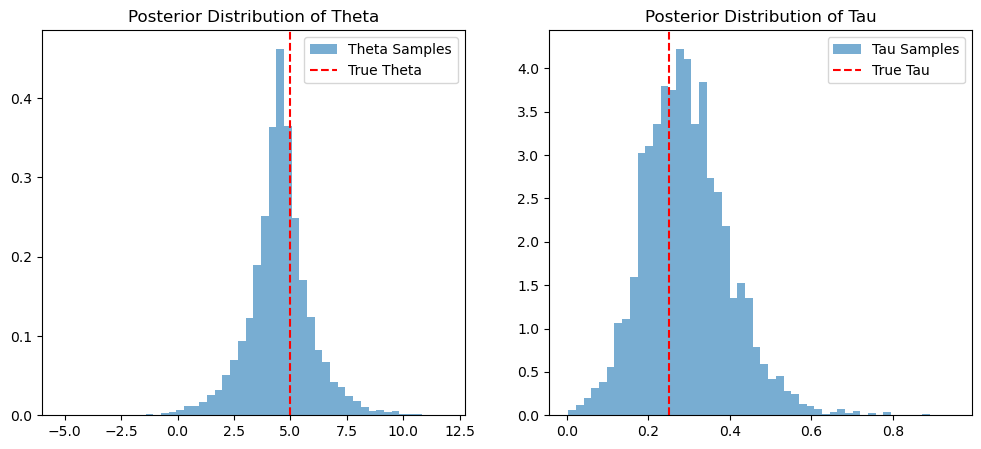

Metropolis-Hastings Acceptance Rate for Tau: 0.287


In [5]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

# Simulated data
np.random.seed(42)
n = 30
theta_true = 5
sigma_true = 2
x = np.random.normal(loc=theta_true, scale=sigma_true, size=n)

# Hyperparameters
mu_0 = 0  # Prior mean for theta (Laplace)
b = 1  # Scale parameter for Laplace
alpha = 2  # Shape for Gamma prior on tau
lambda_ = 2  # Rate for Gamma prior on tau
s = 0.5  # Scale for truncated normal proposal

# Truncated normal proposal function
def truncated_normal_proposal(tau_prev, scale):
    a, b = (-tau_prev / scale, np.inf)
    return stats.truncnorm.rvs(a, b, loc=tau_prev, scale=scale)

# Metropolis-within-Gibbs Sampler
def metropolis_within_gibbs(num_samples):
    theta_samples = np.zeros(num_samples)
    tau_samples = np.zeros(num_samples)

    # Initial values
    theta_samples[0] = np.mean(x)
    tau_samples[0] = 1 / np.var(x)
    acceptance_count = 0

    for i in range(1, num_samples):
        # Sample theta from Laplace distribution
        theta_samples[i] = stats.laplace.rvs(loc=np.median(x), scale=b)

        # Metropolis-Hastings step for tau
        tau_current = tau_samples[i - 1]
        tau_proposal = truncated_normal_proposal(tau_current, s)

        # Compute acceptance ratio
        likelihood_proposed = np.prod(stats.norm.pdf(x, loc=theta_samples[i], scale=1 / np.sqrt(tau_proposal)))
        likelihood_current = np.prod(stats.norm.pdf(x, loc=theta_samples[i], scale=1 / np.sqrt(tau_current)))

        prior_proposed = stats.gamma.pdf(tau_proposal, alpha / 2, scale=2 / lambda_)
        prior_current = stats.gamma.pdf(tau_current, alpha / 2, scale=2 / lambda_)

        acceptance_ratio = min(1, (likelihood_proposed * prior_proposed) / (likelihood_current * prior_current))

        # Accept or reject
        if np.random.rand() < acceptance_ratio:
            tau_samples[i] = tau_proposal
            acceptance_count += 1
        else:
            tau_samples[i] = tau_current

    acceptance_rate = acceptance_count / num_samples
    return theta_samples, tau_samples, acceptance_rate

# Run sampler
num_samples = 10000
theta_mh, tau_mh, accept_rate = metropolis_within_gibbs(num_samples)

# Plot results
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].hist(theta_mh, bins=50, density=True, alpha=0.6, label="Theta Samples")
ax[0].axvline(theta_true, color="red", linestyle="dashed", label="True Theta")
ax[0].legend()
ax[0].set_title("Posterior Distribution of Theta")

ax[1].hist(tau_mh, bins=50, density=True, alpha=0.6, label="Tau Samples")
ax[1].axvline(1 / sigma_true**2, color="red", linestyle="dashed", label="True Tau")
ax[1].legend()
ax[1].set_title("Posterior Distribution of Tau")

plt.show()

# Print acceptance rate
print(f"Metropolis-Hastings Acceptance Rate for Tau: {accept_rate:.3f}")


**Evaluation**

The result from the left plot which is a plot of Posterior Distribution of $\theta$ shows an approximately symmetric graph centered around the true value of $\theta$, the red dashed line. There is a slight heavier tailing on the right side which shows the more uncertainty for higher values. The shape of the graph is a Laplace-like distribution which is good considering that the prior is not normal. I general, there is no major bias detected which means that the sampler is working accordingly.

For the right plot, ie the plot for the Posterior Distribution of $\tau$, shows skewness on the right side and the true value for $\tau$ looks align with the mode of the plot which shows that the which shows a good alignmnet with the value. Hence, overall, the graph looks good and working for the sampler.

Lastly, the acceptance rate for the sampler is 28.7% which is a good rate and shows that the proposal distribution is well tuned.


**Analysis of the Full Conditional Distributions**

In general, based on the previous homeworks and question, we can see that the Gibbs sampler requires more analytical derivation for to find the full conditionals. And it works more efficiently if the full conditional is known. However, this sampler is not as flexible as Metropolis-Hastings as it is very limited depending on the cases when full conditionals exists.

In contrast to the Metropolis-Within-Gibbs, this sampler uses the joint distribution directly and can get a bit slower due to the proposal rejection. However, as seen from this question, this sampler can handle non-conjugate priors which can be useful for non-normal priors.

---
### Question 3

For **Metropolis Hastings** targetting (**stationary distribution**) $p$ based on proposal distribuiton $q$ given below

$\begin{align}
q(\tilde x^{(t)} | x^{(t-1)}) &={} \left(\frac{1}{2}\right)^{1-{\tilde x^{(t)}}}\left(\frac{1}{2}\right)^{\tilde x^{(t)}} \quad \color{gray}{\textrm{ ... does } \quad \frac{q(x^{(t-1)}|\tilde x^{(t)})}{q(\tilde x^{(t)}|x^{(t-1)})} \quad  \textrm{ cancel?}}\\
\textrm{and} \quad p(x^{(t)}) &={} \left(\frac{1}{3}\right)^{1-{x^{(t)}}}\left(\frac{2}{3}\right)^{x^{(t)}}\\
\end{align}$

<u>show that</u> the **transition kernel** $K$ of transition probabilities is defined the **Metropolis Hastings** algorithm is

$K = \left[\begin{array}{cc}\Pr(x^{(t)}=0 \rightarrow x^{(t+1)}=0) & \Pr(x^{(t)}=1 \rightarrow x^{(t+1)}=0)\\\Pr(x^{(t)}=0 \rightarrow x^{(t+1)}=1)& \Pr(x^{(t)}=1 \rightarrow x^{(t+1)}=1)\end{array}\right] = \left[\begin{array}{cl} 0.5 & 0.25 \\ 0.5 & 0.75 \end{array}\right]$

This means that

- if we're currently a $0$ there's a 50\% chance that we'll stay a $0$ and 50\% chance that we'll change to a $1$
- and if we're currently a $1$ there's a 75\% chance that we'll stay a $1$ and 25\% chance that we'll change to a $0$

which specifies [geometric distributions](https://en.wikipedia.org/wiki/Geometric_distribution) with, respectively, expected values of $1$ and $3$ "failures before transitioning to the other state" which means that on average a "$0$ state" will be a run of two $0$'s while a "$1$ state" will be a run of four $1$'s which leads to the desired one-to-two (or one-thirds to two-thirds) ratio of $0$'s and $1$ is the Markov Chain. 

*Answer:*

The **transition kernel** $K$ of transition probabilities is defined the **Metropolis Hastings** algorithm is

$K = \left[\begin{array}{cc}\Pr(x^{(t)}=0 \rightarrow x^{(t+1)}=0) & \Pr(x^{(t)}=1 \rightarrow x^{(t+1)}=0)\\\Pr(x^{(t)}=0 \rightarrow x^{(t+1)}=1)& \Pr(x^{(t)}=1 \rightarrow x^{(t+1)}=1)\end{array}\right] = \left[\begin{array}{cl} 0.5 & 0.25 \\ 0.5 & 0.75 \end{array}\right]$


which means

- if $x^{(t)} = 0$, there's a 50\% chance of staying at $0$ and 50\% chance of changing to $1$
- if $x^{(t)} = 1$, there's a 75\% chance of staying at $1$ and 25\% chance of changing to $0$

This shows that the Markov Chain leads to a stationary distribution of 
- 1/3 of the time in state 0
- 2/3 of the time in state 1

Since the transition probabilities determine how long a state persists before switching, the expected run lengths are:

- For a 0-state expected run length: $1/(1−0.5)=2$ (before switching to 1).
- For a 1-state expected run length: $1/(1−0.75)=4$ (before switching to 0).
Hence, the expected runs of 0s are shorter than the runs of 1s.

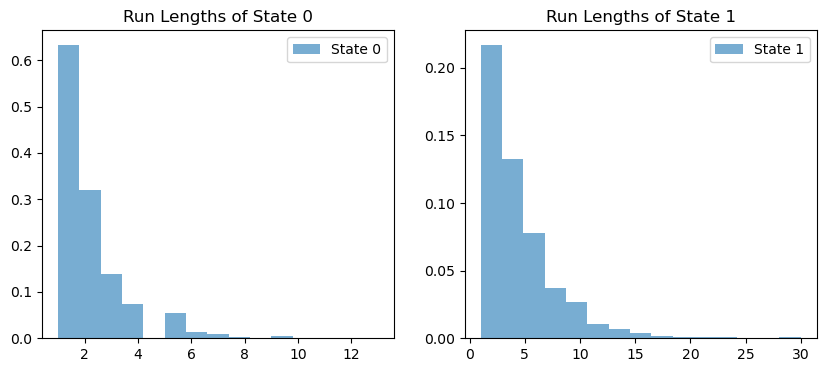

Average run length for state 0: 1.982
Average run length for state 1: 4.052


In [7]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

# Define transition matrix K
K = np.array([[0.5, 0.25], [0.5, 0.75]])

# Simulate Markov Chain
T = 10000  # Number of steps
s_t = np.zeros(T, dtype=int)  # Start at state 0

for t in range(1, T):
    s_t[t] = int(stats.uniform().rvs() < K[:, s_t[t - 1]][1])

# Compute run lengths for state 0 and state 1
state0_run_length = []
state1_run_length = []
run_length = 1

for t in range(1, T):
    if s_t[t] == s_t[t - 1]:
        run_length += 1
    else:
        if s_t[t - 1] == 0:
            state0_run_length.append(run_length)
        else:
            state1_run_length.append(run_length)
        run_length = 1  # Reset run length

# Plot histograms of run lengths
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].hist(state0_run_length, bins=15, density=True, alpha=0.6, label="State 0")
ax[0].set_title("Run Lengths of State 0")
ax[0].legend()

ax[1].hist(state1_run_length, bins=15, density=True, alpha=0.6, label="State 1")
ax[1].set_title("Run Lengths of State 1")
ax[1].legend()

plt.show()

# Print mean run lengths
print(f"Average run length for state 0: {np.mean(state0_run_length):.3f}")
print(f"Average run length for state 1: {np.mean(state1_run_length):.3f}")


**Interpretation**
From the left plot, we can see that the majority of the run lengths is centered around 2 when in the state of $x^{(t)}=0$, with some right skewness, which shows that the system occasionally stays in the state 0 longer than expected. However, the average run length of the state is 1.982 which is very close to our expected value of 2.

For the right plot, the majority of the run lengths is centered around 4, indincating that once the system enters the state of 1, it tends to remain there for an average of 4.052 time steps before tranistioning back to state 0. However, similiar to the run lengths of state 0, the plot is also right-skewed which shows that the system occasionally stays in the state 1 longer than expected.

In general, based on the calculated expected value of the run length of state at value 0 and 1 above, which are 2 and 4 respectively, the average run length of the states are very close. The average run length of 0 is 1.982, close to 2 and the average run length of 1 is 4.052, also close to the exoected value of 4. Hence, the observed run lengths match the theoretical expectations confirming that the Markov Chain behaves as expected.